# This Notebook develops five functions to facilitate analysis of the CAISO wholeale power prices and related variables of interest:

# 1. get_price_series(files),  
# 2. get_hours_histogram(files), 
# 3.plot_price_averages(files) , 
# 4. compare_hourly_prices(files1, files2), and 
# 5. get_OLS(files)

The files are a list of CSV downloads from the CAISO website, which cover 2017 & 2018 in monthly data.
The prices are hourly from the so-called "Day-Ahead-Market" (DAM), since most transactions are conducted on this market, and the Spot Market (RTM) is much less used.
#1 returns an hourly price series for the PG&E main node.
#2 returns a normed histogram for which hour of the day had the lowest price, and displays the respective value counts
#3 plots the hourly mean prices over a given time period encompassed by the files
#4 returns the average hourly price (of 24) for the subject files (eg by month, quarter, or half-year, or period of years) and plots a line chart of the mean hourly prices (and compares it to the year prior same time period).
#5 returns an OLS regression for the subject time period embodied by the files.

In [1]:
import os
print(os.getcwd())

/Users/user/Desktop/CAISO Monthly Prices


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import urllib
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm             # these two imports as used in Boston Housing mini-project
from statsmodels.formula.api import ols

# A QUICK HISTORICAL LOOK AT THE HOURS WITH THE LOWEST PRICES 

In [3]:
H1_18= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']
H2_18= ['DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']

H1_17= ['DAM_Jan_2017.csv','DAM_Feb_2017.csv', 'DAM_March_2017.csv','DAM_May_2017.csv','DAM_June_2017.csv']
# excludes the missing: 'DAM_April_2017.csv'
H2_17= ['DAM_July_2017.csv','DAM_Aug_2017.csv','DAM_Sept_2017.csv','DAM_Oct_2017.csv','DAM_Nov_2017.csv','DAM_Dec_2017.csv']

def get_price_series(files):
    '''This function prints a list of each of the day that had the lowest power price for the days covered by the files'''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    dfp= dfp.sort_index()
    # dfp= dfp.sort_values
    # df_pvt= dfp.pivot('day','hour','price') # Hmm: already vertical column so pivot() wold make HORIZONTAL
    # print(df_pvt.head(3)) drop this as this FN() is called elsewhere
    # print(df_pvt.tail(3))
    return(dfp)

# graphs mean hourly prices for the subject time period (one line only)
def plot_price_averages(files):
    plt.title('Average Hourly Prices for PGE N.California Hub ($/MWh)')
    plt.ylabel('Price')
    plt.ylabel('Hour of the Day')
    df_pm= get_price_series(H1_17)
    df_pm= df_pm.groupby('hour').price.mean().plot()



def get_hours_histogram(files):
    '''This function prints a list of each of the day that had the lowest power price for the days covered by the files'''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    df_pvt= dfp.pivot('day','hour','price') 
    lowest_hours= df_pvt.idxmin(axis=1)       # THIS IS JEFF'S CODE FOR PANDAS SO NO M REQUIRED, NOR ARGMIN()
    plt.hist(lowest_hours, bins= np.arange(1,24,1) - 0.5,density= True)
    plt.title('Histogram of the Hour with the Lowest CAISO Price for the Subject Period ' )
    plt.xlabel('Hour of the Day')
    plt.ylabel('Probability')
    plt.xticks= range(1,25)
    plt.show()
    return pd.Series(lowest_hours).value_counts(sort= False) # this gives the frequencies

In [4]:
get_price_series(H1_17).head(3) #OK, w columns:  hour, price, day

,hour,price,day
date,,,
2017-01-01 08:00:00,1,32.19913,2017-01-01
2017-01-01 09:00:00,2,32.06740,2017-01-01
2017-01-01 10:00:00,3,31.92218,2017-01-01


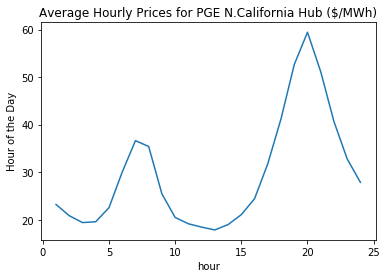

In [5]:
plot_price_averages(H1_17)

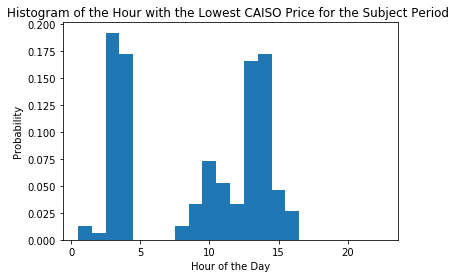

1      2
2      1
3     29
4     26
8      2
9      5
10    11
11     8
12     5
13    25
14    26
15     7
16     4
dtype: int64

In [6]:
get_hours_histogram(H1_17) #OK, w value counts also returned, and a datetime index

In [7]:
def compare_hourly_prices(files1,files2):
    df1= get_price_series(files1) #local variable
    df1= df1.pivot('day','hour','price')
    m1= df1.mean().round(1) # vertical
    df2= get_price_series(files2) #local variable
    df2= df2.pivot('day','hour','price')
    m2= df2.mean().round(1) # vertical
    # now create a df (dfd) to display the actual prices
    dfd= pd.DataFrame()         # pandas.DataFrame.plot
    dfd['first_period']=  m1
    dfd['second_period']= m2
    print(dfd.T.round(1))  # rounds all prices to one decimal places to display better. NEED TO FIX!!
    
    # Now plot the two lines of mean hourly prices
    plt.plot(m1)
    plt.plot(m2)
    plt.title('Average Hourly Prices for PGE N.California Hub ($/MWh)')
    plt.ylabel('Price')
    plt.xlabel('Hour of the Day') # this is OK but NO LEGEND
    
    fig, ax = plt.subplots()
    ax.plot(m1, '-b', label='First Period') # FAILED ATTEMP TO ADD A LEGEND
    ax.plot(m2, '--r', label='Second Period')# HAS A WEIRD SCALE AND V. BAD LOOK!!!!
    # ax.axis('equal')
    leg = ax.legend();
    plt.show()
    
    # Pandas plot (but no labelling of axes nor title, but does have a legend)
    plt.title('Average Hourly Prices for PGE N.California Hub ($/MWh)')
    plt.ylabel('Price')
    plt.xlabel('Hour of the Day')
    dfd.plot() # this works and includes a legend! It appears as the third plot.

hour             1     2     3     4     5     6     7     8     9     10  \
first_period   23.2  20.8  19.4  19.6  22.5  30.0  36.6  35.4  25.4  20.5   
second_period  26.0  24.2  23.0  22.7  24.5  30.3  36.8  31.7  23.6  19.8   

hour           ...     15    16    17    18    19    20    21    22    23  \
first_period   ...   21.1  24.4  31.8  41.2  52.6  59.4  51.2  40.7  32.8   
second_period  ...   17.2  20.2  25.1  33.9  43.3  49.8  48.8  40.0  32.3   

hour             24  
first_period   27.9  
second_period  28.3  

[2 rows x 24 columns]


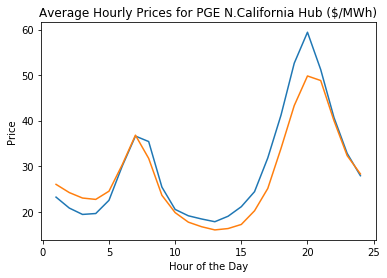

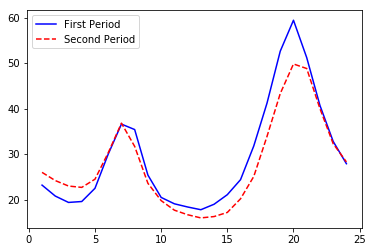

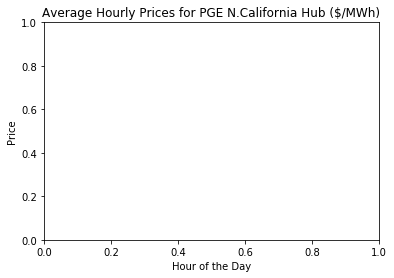

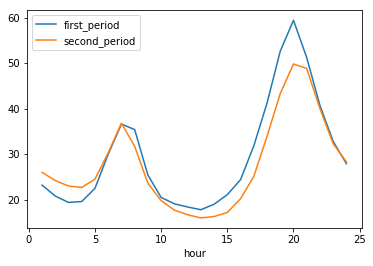

In [8]:
compare_hourly_prices(H1_17,H1_18) # how to stop the new line and have 16 hours on the first line??

In [ ]:
plot_price_averages(H1_17)

In [ ]:
# Comparison of DAM Prices at Hours 3 & 4 with PGE Off-Peak Onset
g= dfp.groupby(by= dfp['hour'])
dfh= g.price.mean()
type(dfh) # pandas.core.series.Series
print(dfh)
print(dfh[3])
discount= 100 * (1 - (dfh[3]+ dfh[4])/(dfh[22]+ dfh[23]))
print('Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak', round(discount,1), '%')
#Commentary
#With the PG&E off-peak period starting at 9pm (which is "Hour 22"), the average price for two hours of charging
#is simply the average of the respective prices. This may be compared to the average prices for Hours 3 & 4. 
#As calculated above, the Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak is c.37%.

In [ ]:
[plot_price_averages(file) for file in H1_18] 

In [ ]:
plt.plot(get_price_series(H1_18[0:3]).mean()) # Ok for a slice: but otherwise FileNotFoundError: File b'D' does not exist

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# PROBLEM: the summary is returned, but is not visible in the wndow until one scrolls down quite a bit

def get_OLS(files):  
    df= get_price_series(files)
    df['weekday']= df['day'].dt.weekday_name.astype('category')
    df['month']= df['day'].dt.month.astype('category')
    df.hour= df.hour.astype('category') 
    # print(df)
    m= ols(formula= 'price ~ hour + weekday + month', data= df).fit()
    print(m.summary())  

In [ ]:
# get_OLS(H1_18)   # R2= 66% w time variables only
# get_OLS(H2_18)   # R2= 22% w time variables only
# get_OLS(H1_17)   # R2= 39% w time variables only
# get_OLS(H2_17)   # R2= 26% w time variables only
two_years= H1_17 + H2_17 + H1_18 + H2_18
get_OLS(two_years) # R2= 28% w time variables only

In [ ]:
two_years= H1_17 + H2_17 + H1_18 + H2_18
len(two_years)# 23 (as April, 2017 is missing)
get_hours_histogram(two_years)

In [ ]:
# THIS FUNCTION DOES AN OLS REGRESSION JUST FOR THE DESIGNATED OFF-PEAK HOURS
def get_OLS_offpeak(files):  
    df= get_price_series(files)
    df['weekday']= df['day'].dt.weekday_name.astype('category')
    df['month']= df['day'].dt.month.astype('category')
    df= df[df['hour'].astype('int').isin(['1','2','3','4','5','6','22','23','24'])]
    #df['hour'].astype('int').isin(['1','2','3','4','5','6','22','23','24'])
    df.hour= df.hour.astype('category') 
    # print(df)
    m= ols(formula= 'price ~ hour + weekday + month', data= df).fit()
    print(m.summary())  

In [ ]:
# get_OLS_offpeak(H1_17)   # R2=72%
# get_OLS_offpeak(H2_17)   # R2=56%
# get_OLS_offpeak(H1_18)   # R2=66%
# get_OLS_offpeak(H2_18)   # R2=38%
get_OLS_offpeak(two_years) # R2=48% So for the off-peak hours fully half of the variability is time related

# Scraping the CAISO Daily Reports for power generation by type

In [14]:

def read_one_day(date):
    link = "http://content.caiso.com/green/renewrpt/{}_DailyRenewablesWatch.txt".format(date)
    url = urllib.request.urlopen(link)
    content = [str(word) for word in url.readlines()] # converting each word of each line to strings

    # Note these are static, so may need to be adjusted.  Looks to be the same each day though.
    # Could be possible to parse on the fly, but start simple for now
    renewable_columns = ['hour', 'geo', 'biom', 'biog', 'shydro', 'wind', 'solarPV', 'sTH']
    renewable_data = content[2:26]    
    total_columns = ['hour', 'srnwbls','nucl', 'thermal', 'imports', 'lhydro']
    total_data = content[30:]    
    
    parsed_renewable = [parse_array(row) for row in renewable_data] # calling function below w 3 Regular Expression calls
    parsed_total = [parse_array(row) for row in total_data] # same
    
    renewable = pd.DataFrame(parsed_renewable, columns=renewable_columns)
    total = pd.DataFrame(parsed_total, columns=total_columns)
    
    renewable['DATE'] = date
    total['DATE'] = date
    df= pd.merge(renewable,total,on= 'hour')  # s = pd.Series(["a", "b", "c", "a"], dtype="category")//pd.series( ,dtype= 'category') rejected
    df.hour= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
    df['DT'] = pd.to_datetime(df['DATE_y'] + ' ' + df['hour'] + ':00:00')
    df.set_index(df['DT'], inplace= True)
    df= df.drop(['DATE_x','DATE_y','DT'], axis=1)
    # df['hour']= df['hour'].astype('category', ordered=True)# categories=[2, 1]
    # FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
    return df
    
def parse_array(one_row):
    no_chars = re.sub(r"[a-zA-Z']", "", one_row) # were commas used to denote thousands (so needed to be removed)
    no_slashes = re.sub(r"\\+", ",", no_chars)
    splitted_strings = no_slashes[1:-1].split(',')
    return [int(elem) for elem in splitted_strings] # interesting syntax! return a List Comprehension!
# after parsing numbers converted back to numeric for Pandas read

In [15]:
def read_one_month(year_month):  # see datetime lectures Chapter 4
    if year_month[4:6] in ['04','06','09','11']:
        d= 31
    elif year_month[4:6] == '02':
        d=29
    else:
        d=32
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,d))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc

In [55]:
# Completed Work for the first six months of 2018 (H1 2018)

H1_18_gen_dates= [('2018'+ rest) for rest in ['01','02','03','04','05','06']]
H1_18_gen_dates

H1_18_gen_dfs= [read_one_month(month) for month in H1_18_gen_dates]     # response ONLY after two minutes!
H1_18_gen_dfs[0] # H1_18_gen_files is a list of df's

H1_18_gen_data = pd.concat(H1_18_gen_dfs)
print(H1_18_gen_data.head(3))
H1_18_gen_data.info()
print(H1_18_gen_data.tail(3))


                    hour  geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                      
2018-01-01 00:00:00   00  975   304   214     299   236        0    0   
2018-01-01 01:00:00   01  976   304   215     301   277        0    0   
2018-01-01 02:00:00   02  975   304   216     301   128        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2018-01-01 00:00:00     2028  2260     7236     7501    2102  
2018-01-01 01:00:00     2073  2259     6702     7453    2043  
2018-01-01 02:00:00     1924  2260     6266     7498    2033  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2018-01-01 00:00:00 to 2018-06-30 23:00:00
Data columns (total 13 columns):
hour       4344 non-null object
geo        4344 non-null int64
biom       4344 non-null int64
biog       4344 non-null int64
shydro     4344 non-null int64
wind       4344 non-

In [56]:
type(H1_18_gen_data)

pandas.core.frame.DataFrame

In [57]:
# write to a csv file for storage for convenient future use
H1_18_gen_data = H1_18_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H1_18_gen_data.csv', 
                                        index = 'DT', header=True) 


# H1_17 below does not run!! (but H2_17, H1_18 & H2_18 all do run)

In [35]:
H1_17_gen_dates= [('2017'+ rest) for rest in ['01','02','03','04','05','06']]
H1_17_gen_dates

H1_17_gen_dfs= [read_one_month(month) for month in H1_17_gen_dates]     # response ONLY after two minutes!
H1_17_gen_dfs[0] # H1_17_gen_files is a list of df's

H1_17_gen_data = pd.concat(H1_17_gen_dfs)
print(H1_17_gen_data.head(3))
H1_17_gen_data.info()
print(H1_17_gen_data.tail(3))   # ValueError: invalid literal for int() with base 10: '"  

ValueError: invalid literal for int() with base 10: '"      .   '

In [58]:
H2_18_gen_dates= [('2018'+ rest) for rest in ['07','08','09','10','11','12']]
H2_18_gen_dates

H2_18_gen_dfs= [read_one_month(month) for month in H2_18_gen_dates]     # response ONLY after two minutes!
H2_18_gen_dfs[0] # a list of df's

H2_18_gen_data = pd.concat(H2_18_gen_dfs)
print(H2_18_gen_data.head(3))
H2_18_gen_data.info()
print(H2_18_gen_data.tail(3))  

                    hour  geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                      
2018-07-01 00:00:00   00  992   342   223     347  4087        0    0   
2018-07-01 01:00:00   01  994   343   223     341  4053        0    0   
2018-07-01 02:00:00   02  994   344   223     310  3919        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2018-07-01 00:00:00     5991  2268     7648     6776    2585  
2018-07-01 01:00:00     5954  2267     6245     7007    2400  
2018-07-01 02:00:00     4796  2259     6286     7170    2360  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-07-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 13 columns):
hour       4416 non-null object
geo        4416 non-null int64
biom       4416 non-null int64
biog       4416 non-null int64
shydro     4416 non-null int64
wind       4416 non-

In [59]:
# write to a csv file for storage for convenient future use
H2_18_gen_data = H2_18_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_18_gen_data.csv', 
                                        index = 'DT', header=True) 

In [51]:
H2_17_gen_dates= [('2017'+ rest) for rest in ['07','08','09','10','11','12']]
H2_17_gen_dates

H2_17_gen_dfs= [read_one_month(month) for month in H2_17_gen_dates]     # response ONLY after two minutes!
H2_17_gen_dfs[0] # a list of df's

H2_17_gen_data = pd.concat(H2_17_gen_dfs)
print(H2_17_gen_data.head(3))
H2_17_gen_data.info()
print(H2_17_gen_data.tail(3))

                    hour   geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                       
2017-07-01 00:00:00   00  1025   226   184     482  3629        0    0   
2017-07-01 01:00:00   01  1025   226   184     481  3575        0    0   
2017-07-01 02:00:00   02  1025   228   185     477  3630        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2017-07-01 00:00:00     5514  2277     6182     7510    4075  
2017-07-01 01:00:00     5491  2278     4715     7377    4074  
2017-07-01 02:00:00     5545  2278     3625     7411    4068  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2017-07-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 13 columns):
hour       4416 non-null object
geo        4416 non-null int64
biom       4416 non-null int64
biog       4416 non-null int64
shydro     4416 non-null int64
wind       4416

In [52]:
# write to a csv file for storage for convenient future use
H2_17_gen_data = H2_17_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_17_gen_data.csv', 
                                       index= 'DT', header=True) 

In [73]:
H2_17G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_17_gen_data.csv', index_col= 'DT') 
test_read.head(3)

,DT,hour,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
0,2017-07-01 00:00:00,0,1025,226,184,482,3629,0,0,5514,2277,6182,7510,4075
1,2017-07-01 01:00:00,1,1025,226,184,481,3575,0,0,5491,2278,4715,7377,4074
2,2017-07-01 02:00:00,2,1025,228,185,477,3630,0,0,5545,2278,3625,7411,4068


In [74]:
H2_18G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_18_gen_data.csv',index_col= 'DT')

In [75]:
H1_18G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H1_18_gen_data.csv',index_col= 'DT')

In [85]:
dfgc= pd.concat([H2_17G, H1_18G,H2_18G]) #dfgc is the df's Generating Consolidated, here spanning 18 months

In [86]:
print(len(dfgc)) # the number of hours spanned (here for 18 months)
dfc.head(3)

13176


,hour,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
DT,,,,,,,,,,,,,
2017-07-01 00:00:00,0,1025,226,184,482,3629,0,0,5514,2277,6182,7510,4075
2017-07-01 01:00:00,1,1025,226,184,481,3575,0,0,5491,2278,4715,7377,4074
2017-07-01 02:00:00,2,1025,228,185,477,3630,0,0,5545,2278,3625,7411,4068


In [87]:
# we need to merge with CAISO prices! (DT is still a column and load is already introduced as a variable)

In [83]:
get_price_series(H1_17).head(3) # we need to create a CA time datetime index, 

,hour,price,day
date,,,
2017-01-01 08:00:00,1,32.19913,2017-01-01
2017-01-01 09:00:00,2,32.06740,2017-01-01
2017-01-01 10:00:00,3,31.92218,2017-01-01


In [101]:
dfpc= pd.concat([get_price_series(H2_17),get_price_series(H1_18),get_price_series(H2_18)])# Prices Consolidated

In [102]:
dfpc.hour= dfpc.hour.astype('category') # even though now a categorical variable, still no broadcasting!

In [103]:
dfpc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13177 entries, 2017-07-01 07:00:00 to 2019-01-01 07:00:00
Data columns (total 3 columns):
hour     13177 non-null category
price    13177 non-null float64
day      13177 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 322.5 KB


In [105]:
dfpc= dfpc.pivot(index= 'day',columns= 'hour', values= 'price')


In [106]:
dfpc.columns= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23','25'] # ValueError: Length of values does not match length of index: NO BROADCASTING!!

In [107]:
dfpc.head(2)

,00,01,02,03,04,05,06,07,08,09,...,15,16,17,18,19,20,21,22,23,25
day,,,,,,,,,,,,,,,,,,,,,
2017-07-01,30.45000,25.01777,27.22040,23.83924,23.71329,24.86218,20.90412,13.97944,10.51006,13.45180,...,27.91586,31.00000,34.24536,39.74598,50.46233,48.73126,41.38012,32.14099,29.07179,NaN
2017-07-02,25.51645,23.38522,25.42727,24.75996,24.80005,25.16132,21.89304,11.80617,9.11610,9.59645,...,27.73144,29.73995,32.88751,39.65068,50.86344,50.68040,42.61538,32.01566,27.20471,NaN


In [108]:
dfpc= dfpc.drop(['25'],axis=1)

In [109]:
dfpc.head(2)

,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2017-07-01,30.45000,25.01777,27.22040,23.83924,23.71329,24.86218,20.90412,13.97944,10.51006,13.45180,...,26.21352,27.91586,31.00000,34.24536,39.74598,50.46233,48.73126,41.38012,32.14099,29.07179
2017-07-02,25.51645,23.38522,25.42727,24.75996,24.80005,25.16132,21.89304,11.80617,9.11610,9.59645,...,23.49277,27.73144,29.73995,32.88751,39.65068,50.86344,50.68040,42.61538,32.01566,27.20471


In [ ]:
# dfpc=# fpc.melt(['id_vars=None', 'value_vars=None', 'var_name=None', "value_name='value'",

In [114]:
dfpc.melt(id_vars= 'day', value_vars=None, var_name='hour', value_name= 'price') 

KeyError: 'day'

In [84]:
dfpc['DT']= pd.to_datetime(dfpc['day'] + '' + dfpc.hour + ':00:00')

In [ ]:
# one way to make the hours line up should be to merge the two df's (df & dfp) on the datetime index

# dfc= pd.merge(df,dfp, how= 'inner', left_on= df.index, right_on= dfp.index)
dfc= pd.merge(df,dfp, how= 'inner', left_on= df.index, right_on= dfp.index)

dfc.head() 
# note that for CAISO prices, the datetime is UK time, but for the scraped data the hour was imputed (so 7 hour delta)

In [68]:
dfc['load']= dfc['srnwbls'] + dfc['nucl'] + dfc['thermal'] + dfc['imports'] + dfc['lhydro']
# WE DROP 'DAY' HERE BUT MIGHT RETAIN FOR GROUPBY??
dfc.index.names= ['date']
dfc= dfc.rename(columns= {'hour_y': 'hour'})
dfc['hour']= dfc['hour'].astype('category')
dfc['weekday']= dfc['weekday'].astype('category')
dfc['month']= dfc['month'].astype('category')
dfc['hour']= dfc['hour'].astype('str')
dfc.info()


import statsmodels.api as sm
from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf
m= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month',
       data= dfc).fit()  # .fit() already done (chained)

print(m.summary())

KeyError: 'weekday'

# Commentary
All variables except nuclear have statistically significant t-values.
However, some have a positive effect on prices rather than a negative one (such as wind and solarPV).
These surprises may be due to multicollinearity
For example, load has a negative coefficient although common sense would suggest the opposite.

In [ ]:
# So we drop nuclear, and also 'load' to hopefully reduce multicollinearity
# We see that the signs of the 'wind' & 'solarPV' variables have now switched, and make sense
# With an adjusted R-squared of 71%, this is a credible starting point for predicting all 24 hours of the day

In [ ]:

m2= ols(formula= 'price ~ wind + solarPV +  thermal + imports + lhydro + hour + weekday + month', data= dfc).fit()

print(m2.summary())

dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:30] # OK
sum(dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:24]) # also OK

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2019-01-01 00:00:00 to 2019-01-31 23:00:00
Data columns (total 13 columns):
hour       744 non-null object
geo        744 non-null int64
biom       744 non-null int64
biog       744 non-null int64
shydro     744 non-null int64
wind       744 non-null int64
solarPV    744 non-null int64
sTH        744 non-null int64
srnwbls    744 non-null int64
nucl       744 non-null int64
thermal    744 non-null int64
imports    744 non-null int64
lhydro     744 non-null int64
dtypes: int64(12), object(1)
memory usage: 81.4+ KB


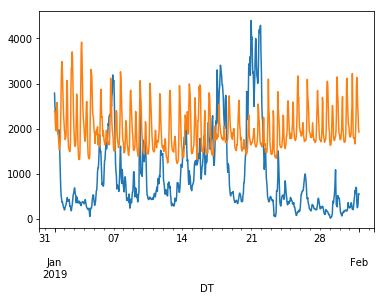

In [44]:
dfc= read_one_month('201901')
dfc.info() # 31 DAYS x 24 HOURS GIVES 744
dfc.tail()

dfc.wind.plot()
dfc.lhydro.plot()
plt.show()

Text(0, 0.5, 'Large Hydro (MWh)')

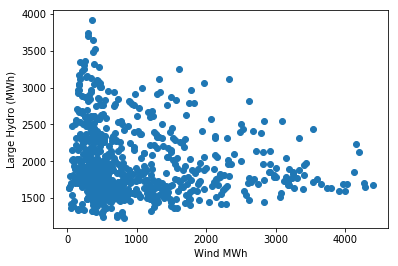

In [42]:
plt.scatter(dfc['wind'], dfc['lhydro'])
plt.xlabel("Wind MWh")
plt.ylabel("Large Hydro (MWh)")

# Commentary
# The median wind output for thine one month of January is surprisingly steady throughout the hours, unlike MISO levels.
# However, the means may be more variable, being influenced by possible huge outliers.

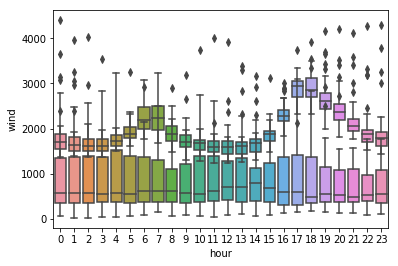

In [19]:
dfc['hour']= dfc['hour'].astype('int') # wanted to plot as an ordered categorical variable but thrown an error
#plt.boxplot(dfc['lhydro'], dfc['hour'])
import seaborn as sns
sns.boxplot(x="hour", y="lhydro", data=dfc)
# From this plot the noon levels are 3300 vs 2200 for 3am, so 50% higher: used to back-up solar due to clouds?
# Why does it climb from hours 20 to 24, so 8pm to midnight!! Not Solar imports, as sun set earlier!!
# Plot versus price volatility in terms of std? Used as back-up (low-carbon)
# NB THIS ISJUST FOR JANUARY, REPEAT FOR 6 MONTHS !!

sns.boxplot(x= "hour", y= "wind", data= dfc)



# Commentary
The median wind output for this one month of January is surprisingly steady throughout the hours, unlike MISO levels.
However, the means may be more variable, being influenced by possible huge outliers.

In [21]:
twelve_months= [('2018'+ rest) for rest in ['01','02','03','04','05','06','07','08','09','10','11','12']]
twelve_months # OK

['201801',
 '201802',
 '201803',
 '201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811',
 '201812']

In [22]:
# This version unnecesssary as the Code above does run, just with a delay of 2 minutes
# half_year= [read_one_month(month) for month in [('2018'+ rest) for rest in ['01','02','03','04','05','06']]]

one_year_data= read_one_month(twelve_months) # TypeError: can only concatenate list (not "str") to list
one_year_data.head(10)
# OK for 0,1,2,3,4,5,6,7,8,9,10,11 : which comprises the whole year!
#checked one month at a time!), as a precursor to the above



TypeError: can only concatenate list (not "str") to list

In [ ]:
# Graphing six_months_data

# six_months_data.info() # datetime index, hour as strings, rest are all type 'int'
df= six_months_data.copy()
x= range(1,4345) # number of hours
y= [df.nucl, df.wind, df.solarPV, df.lhydro, df.thermal,df.imports]
plt.stackplot(x,y,labels= ['nuclear', 'wind','solarPV','Lhydro','thermal','imports'])
plt.xticks([720,1440,90,2160,2880,3600])  # these are in Hours, not days!
plt.xlabel('Day')
plt.ylabel('Power Generation (GWh)')
plt.title('Daily Power Generation')
plt.legend(loc= 'upper left')
plt.show()                      # Completely overcrowded, so plot monthly in a pane of six months

In [ ]:
dfc['load']= dfc['srnwbls'] + dfc['nucl'] + dfc['thermal'] + dfc['imports'] + dfc['lhydro']
# WE DROP 'DAY' HERE BUT MIGHT RETAIN FOR GROUPBY??
dfc.index.names= ['date']
dfc= dfc.rename(columns= {'hour_y': 'hour'})
dfc['hour']= dfc['hour'].astype('category')
dfc['weekday']= dfc['weekday'].astype('category')
dfc['month']= dfc['month'].astype('category')
dfc['hour']= dfc['hour'].astype('str')
dfc.info()


# need to add dummies and carve out the night hours
dfc.head()
dfc.tail(10)
dfc.hour[0:30] # Hmm all 24 hours do appear and in order
dfc.hour[240:270] # also OK here



df_wD= pd.get_dummies(dfc, drop_first= True)  # columns= [dfc.hour, dfc.weekday, dfc.month]

import statsmodels.api as sm
from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf
m= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month',
       data= dfc).fit()

# .fit() already above

print(m.summary())

# Commentary
Allvariables except nuclear have statistically significant t-values.
However, some have a positive effect on prices rather than a negative one (such as wind and solarPV).
These surprises may be due to multicollinearity
For example, load has a negative coefficient although common sense would suggest the opposite.

# So we drop nuclear, and also 'load' to hopefully reduce multicollinearity
# We see that the signs of the 'wind' & 'solarPV' variables have now switched, and make sense
# With an adjusted R-squared of 71%, this is a credible starting point for predicting all 24 hours of the day
m2= ols(formula= 'price ~ wind + solarPV +  thermal + imports + lhydro + hour + weekday + month', data= dfc).fit()

print(m2.summary())

dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:30] # OK
sum(dfc['hour'].isin(['1','2','3','4','5','6','23','24'])[0:24]) # also OK



In [ ]:
# Now we focus the model exclusively on the off-peak hours of interest
dfw= dfc[dfc['hour'].isin(['1','2','3','4','5','6','23','24'])]

dfw.head(10) # now OK 

# Unlke scikitlearn, dummies are automatically created with statsmodel
# correct data specified? Two lines of code
mw1= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month ',
         data= dfw).fit()

# OLD OUTPUT
print(mw1.summary()) # Hmm very strange: we have MORE THAN 24 HOURS WHEN WE SHOULD HAVE JUST seven!!!
# THIS ERROR AROSE AS 'data' had not been updated to dfw_wD

# Import CAISO Hourly DAM Prices: Completed Six Months Analysis


In [ ]:
files= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']
# files= ['DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']

frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
df1= pd.concat(frames)
dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
dfp.columns= ['hour','price','day']
dfp['weekday']= dfp.day.dt.weekday_name
dfp['month']= dfp.day.dt.month #new code
dfp.index.names= ['date']
# dfp.index= dfp.index.drop_duplicates(keep='first')  
# dfp = dfp.sort_values(dfp.index) UNABLE TO SORT DUE TO DUPLICATES, BUT UNABLE TO REMOVE DUPLICATES W CODE ABOVE
dfp.info()  # WE HAVE 4343 OBSERVATIONS (AS HOURS), but the scraped data has 4344 hours: MAKE SURE NOT OFF BY AN HOUR!!
print(dfp.head())
print(dfp.tail()) # dfp is dataframe for Prices


# NB price is now a vertical series and the use of pivot will now make it HORIZONTAL!! (as happens below)

In [ ]:
# first drop excess variables
df_pvt= dfp.drop(columns= dfp[['weekday','month']], axis=1)
df_pvt= dfp.pivot('day','hour','price') 
# NB Some Nan in the last row (gives rise to the sole value of Hour 17 below??
df_pvt.head(3)


In [ ]:
M= df_pvt.values  #argmin in NOT a Pandas method, so first we make a matrix, M.
lowest_hours= M.argmin(axis=1)
print(type(lowest_hours)) # numpy.ndarray
print(len(lowest_hours)) # 181 (so Nan's did indeed effect the last day)
print(lowest_hours)

In [ ]:
# This is for H2
# Something weird here: lowest hour is 24 everythime, which is not correct!!!
plt.hist(lowest_hours, bins= np.arange(1,24,1) - 0.5,density= True)
plt.title('Histogram of the Hour with the Lowest CAISO Price for the period 2018:H1' )
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks= range(1,25)
plt.show()
# IMPROVE THIS W CALTECH CODE FOR EXACT SPECIFICATION OF BINS/bin edges (DWW TRY 17, SINCE NONE > 17)
# ALSO PRINT THE COUNT FOR EACH HOUR!

In [ ]:
# np.arange(0,14 + 1.5)- 0.5 # centered around 0 to 14 This is the CalTech code
bins= np.arange(0,24 + 1.5)- 0.5

In [ ]:
# This is for H1
plt.hist(lowest_hours, bins= np.arange(0,24 + 1.5)- 0.5,density= True)
plt.title('Histogram of the Hour with the Lowest CAISO Price for the period 2018:H1' )
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks= range(1,25)
plt.show()
# IMPROVE THIS W CALTECH CODE FOR EXACT SPECIFICATION OF BINS/bin edges (DWW TRY 17, SINCE NONE > 17)
# ALSO PRINT THE COUNT FOR EACH HOUR!

# Commentary
For this six month period, the lowest prices occured at night only in Python index positions 2 & 3, corresponding to hours '3' & '4'.
So from a Classification viewpoint, a simple model with dummy variables for the respective hours would have performed with 100% accuracy.
We should extend the time period to at least a full year, and ideally several years.
The histogram formatting with respect to the edges is still not quite right:
see https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram



# df.idxmin( ) Variation suggested by Jeff: runs fine for H1

In [ ]:
# first drop excess variables
df_pvt= dfp.drop(columns= dfp[['weekday','month']], axis=1)
df_pvt= dfp.pivot('day','hour','price') 
# NB Some Nan in the last row (gives rise to the sole value of Hour 17 below??


In [ ]:
lowest_hours= df_pvt.idxmin(axis=1)
print(type(lowest_hours)) # numpy.ndarray
print(len(lowest_hours)) # 181 (so Nan's did indeed effect the last day)
print(lowest_hours)

In [ ]:
# This is for H1
plt.hist(lowest_hours, bins= np.arange(0,24 + 1.5)- 0.5,density= True)
plt.title('Histogram of the Hour with the Lowest CAISO Price for the period 2018:H1' )
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks= range(1,24)
plt.show()

# Repeat with streamlined "Production Code" for H2 of 2018

In [ ]:
print(len(lowest_hours)) # 181 ??, when it should be 31 !!
lowest_hours  # this looks correct, BUT NOTE W PYTHON ZERO INDEXING THAT 3 IS IN FACT THE 4TH HOUR !! ETC

In [ ]:
H1= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']
files= ['DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']

def get_hours_histogram(files):
    '''This function prints a list of each of the day that had the lowest power price for the days covered by the files'''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    df_pvt= dfp.pivot('day','hour','price') 
    lowest_hours= df_pvt.idxmin(axis=1)       # THIS IS JEFF'S CODE FOR PANDAS SO NO M REQUIRED, NOR ARGMIN()
    # M= df_pvt.values  #argmin in NOT a Pandas method, so first we make a matrix, M.
    # VERY ODDLY, RUNS OK FOR H1, BUT FOR THE H2 FILES, EVERY ELEMENT OF M IS EQUAL TO 24!
    # return M
    # lowest_hours= M.argmin(axis=1)
    print(lowest_hours)
    # fn worked for H1, as before
    plt.hist(lowest_hours, bins= np.arange(1,24,1) - 0.5,density= True)
    plt.title('Histogram of the Hour with the Lowest CAISO Price for the Subject Period ' )
    plt.xlabel('Hour of the Day')
    plt.ylabel('Probability')
    plt.xticks= range(1,25)
    plt.show()

In [ ]:
get_hours_histogram(files)

# Full Year 2018

In [ ]:
year_2018= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv',
            'DAM_June_2018.csv','DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv',
            'DAM_Nov_2018.csv','DAM_Dec_2018.csv']
get_hours_histogram(year_2018)

In [ ]:
# Commentary
For the full year 2018, we can see that with respect to the off peak hours starting at 9pm, 

# H2 2018 Analysis

In [ ]:
print(get_hours_histogram(files))

In [ ]:
files= ['DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv',
     'DAM_Dec_2018.csv']
get_hours_histogram(files)

In [ ]:
# plt.hist(get_hours_histogram(files), bins= np.arange(1,24,1) - 0.5,density= True)
# the above returns lowest_hours, not hist: but data is for H2 ...so an improvement!!
plt.hist(lowest_hours, bins= np.arange(1,24,1) - 0.5,density= True)
plt.title('Histogram of the Hour with the Lowest CAISO Price for the Subject Period ' )
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks= range(1,25)
plt.show()
# IMPROVE THIS W CALTECH CODE FOR EXACT SPECIFICATION OF BINS/bin edges (DWW TRY 17, SINCE NONE > 17)
# ALSO PRINT THE COUNT FOR EACH HOUR!

# 2. Comparison of DAM Prices at Hours 3 & 4 with PGE Off-Peak Onset

# Commentary
With the PG&E off-peak period starting at 9pm (which is "Hour 22"), the average price for two hours of charging is simply the average of the respective prices. This may be compared to the average prices for Hours 3 & 4.
As calculated above, the Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak is c.37%.

# December 2018

In [ ]:
DEC= read_one_month('201812')

In [ ]:
DEC.tail()

In [ ]:
OCT= read_one_month('201810') # temp variable d is the number of days in the month, plus one.
def read_one_month(year_month):
    if year_month[4:6] in ['04','06','09','11']:
        d= 31
    elif year_month[4:6] == '02':
        d=29
    else:
        d=32
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,d))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc

In [ ]:
twelve_months= [('2018'+ rest) for rest in ['01','02','03','04','05','06','07','08','09']] + \
['201810','201811','201812']
twelve_months

# This did run at 9am, before start of Caiso day?
This did not run before, but no error message (possibly exceeded CAISO limit?)

In [ ]:
one_year_data= [read_one_month(month) for month in twelve_months] 
# This did not run, but no error message (possibly exceeded CAISO limit?)

In [ ]:
one_year_data[11] # one year data is a list of df's, that need to be concatenated

In [ ]:
df2018= pd.concat(one_year_data)

In [ ]:
df2018.info()

In [ ]:
df2018.tail()

# H2 2018  Are only Hours starting at 2am & 3am the lowest for this period also?
 Can also concatenate to make a full year and extend the regression analysis

In [ ]:
H2_2018_months=  [('2018'+ rest) for rest in ['07','08','09']] + ['201810','201811','201812']
H2_2018

In [ ]:
H2_2018_data= [read_one_month(month) for month in H2_2018_months]     # response ONLY after two minutes?

In [ ]:
df18H2 = pd.concat(H2_2018_data)
df18H2.info()
df18H2.tail()

# Import CAISO Hourly DAM Prices: Completed Six Months Analysis

In [ ]:
# 

In [ ]:
df_pvt.head(3)

In [ ]:
import numpy as np    
hist, bin_edges = np.histogram([1, 1, 2, 2, 2, 2, 3], bins = range(5))
Below, hist indicates that there are 0 items in bin #0, 2 in bin #1, 4 in bin #3, 1 in bin #4.

print(hist)
# array([0, 2, 4, 1])   
bin_edges indicates that bin #0 is the interval [0,1), bin #1 is [1,2), ..., bin #3 is [3,4).

print (bin_edges)
# array([0, 1, 2, 3, 4]))  

In [ ]:
hist = np.histogram(lowest_hours, bins = range(1,24))

print(hist)

# bin_edges indicates that bin #0 is the interval [0,1), bin #1 is [1,2), ..., bin #3 is [3,4).

# print (bin_edges)
 

# Argmax
import numpy as np    
A = np.matrix([[1,2,3,33],[4,5,6,66],[7,8,9,99]])

np.argmax(A)  # 11, which is the position of 99

np.argmax(A[:,:])  # 11, which is the position of 99

np.argmax(A[:1])  # 3, which is the position of 33

np.argmax(A[:,2])  # 2, which is the position of 9

np.argmax(A[1:,2])  # 1, which is the position of 9

In [ ]:
import numpy as np    
A = np.matrix([[1,2,3,33],[4,5,6,66],[7,8,9,99]])
A

In [ ]:
np.argmax(A[:1])  # 3, which is the position of 33



In [ ]:
np.argmax(A[:,2])  # 2, which is the position of 9



In [ ]:
np.argmax(A[1:,2])  # 1, which is the position of 9

In [ ]:
import numpy as np    
A = np.matrix([[1,2,3,33],[4,5,6,66],[7,8,9,99]])
A
np.argmax(A[:0],axis=0) # when i=0, should be the first row

In [ ]:
A.argmax(1)  # this is NOT numpy, but regular python. 

In [ ]:
# numpy.matrix.argmax

matrix.argmax(axis=None, out=None)[source]
Indexes of the maximum values along an axis.

Return the indexes of the first occurrences of the maximum values along the specified axis. If axis is None, the index is for the flattened matrix.

Parameters:	
See `numpy.argmax` for complete descriptions
See also
numpy.argmax

Notes

This is the same as ndarray.argmax, but returns a matrix object where ndarray.argmax would return an ndarray.

Examples

>>>
>>> x = np.matrix(np.arange(12).reshape((3,4))); x
matrix([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
>>> x.argmax()            # for the flattened array
11
>>> x.argmax(0)           # axis = 0, the maximum for the column occurs in the 3rd row
matrix([[2, 2, 2, 2]])

>>> x.argmax(1)           # axis= 1 ; in each case the maximum for the ROW occurs in the third column!!
matrix([[3],               # we want to know which column, so M.argmax(1)
        [3],
        [3]])

In [ ]:
list(range(3))

In [ ]:
[np.argmax(A[:i],axis=0) for i in list(range(3))]

# Various tests below on scraping different months and combinations of months.

In [ ]:
one_year[0].head()# OK

In [ ]:
OCT.head()

In [ ]:
NOV= read_one_month('201811')

In [ ]:
NOV.tail()

In [ ]:
JAN= read_one_month('201901')
JAN.head()

In [ ]:
type(JAN)

In [ ]:
four_months= pd.concat(OCT, NOV, DEC, JAN) 
#TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"
four_months.shape

In [ ]:
dfc= pd.concat(dfs)        # dfc for dataframes concatenated
dfc.shape # 744 hours, 13

In [ ]:
dfc.tail()

In [ ]:
df.info()
df.head(3)

In [ ]:
df.DD= pd.to_datetime()

In [ ]:
import pandas as pd  #Hmm, NOT tab-separated as blank columns inserted to accommodate long names!!

def text_to_df(file):

    df1= pd.read_csv(file, sep= '\s+',skiprows = 2, header= None, nrows= 24)
    df1.columns= ['hour','geo','biom','biog','shydro','wind','solar','solth']
    df2= pd.read_csv(file,sep= '\s+',skiprows = 30, header= None, nrows= 24)
    df2.columns= ['hour','SRnwbls','nucl','thermal','imports','lhydro']
    df2['load']= df2.hour + df2.SRnwbls + df2.nucl + df2.thermal + df2.imports + df2.lhydro
    df2['netload'] = df2.load - df2.SRnwbls
    df= pd.merge(df1,df2,on= 'hour')
    return df


In [ ]:
df= text_to_df('20190114_DailyRenewablesWatch.txt')
print(df.head(2))


In [ ]:
# THE requests package is much better than antiquated urllib (from DS)
# better to use that!
import requests
url= 'http://content.caiso.com/green/renewrpt/20190114_DailyRenewablesWatch.txt'
r= requests.get(url)# where r is the "Response"
jan14= r.text # is this necessary as we already have a .txt file (not HTML)
#save file w 

jan14file= open('jan14.txt', 'wb') # where wb is write binary: this saves the file (?) 

In [ ]:
# So the code runs on the downloaded file, but NOT on the API call using the requests.get() approach

In [ ]:
df_caiso_jan14= text_to_df(jan14)#does not exist!!
# df_caiso_jan14= text_to_df(jan14file) # UnsupportedOperation: read
df_caiso_jan14= text_to_df(r) # Error: Invalid file path or buffer object type: <class 'requests.models.Response'>
# DWW TRY STACK OVERFLOW FOR REFERENCES: ALSO LENOVO

In [ ]:
# we can just keep repeating with multiple df's to see them all on the same plot
import matplotlib.pyplot as plt
plt.xlabel('Hour of the Day')
plt.ylabel('Net Load (in GW)')
plt.title('The Characteristic California Solar-Driven Duck Curve: Hourly Net Load')

plt.plot(df['hour'], df['netload'])# need to convert to Numpy array first?, eg via npm= df.values: apparently NOT
plt.show()


In [ ]:
# Do we have the urllib library in the Anaconda distribution? It seems so, as no error thrown
from urllib.request import urlretrieve
url= 'http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190114_DailyRenewablesWatch.txt'
#NB the other daily file with all the charts is not a txt file, so will not be found!!
urlretrieve( url, 'report20190114.txt')


In [ ]:
file= 'report20190114.txt'

In [ ]:
print(file)#Hmmm: check Hugo tutorial and printing the file, so we can understand how to read it!!!

In [ ]:
text_to_df('report20190114.txt') # Error tokenizing data. C error: Expected 5 fields in line 6, saw 28
# Hmm: confusing. why line 6? 28 columns seems too large vs. the 8 columns in df1 !?

In [ ]:
# Now try it for january 12th, with automatic download from the CAISO website (RE-TYPE inverted commas if pasted!!)
url2='http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190112_DailyRenewablesWatch.txt'

In [ ]:
# paste from above then modify
url2= 'http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/20190112_DailyRenewablesWatch.txt'

In [ ]:
urlretrieve( url2, 'report20190112.txt') # naming the locally downloaded file for the January 12th text file
# error message went away after retyping the pasted commas!!

In [ ]:
text_to_df('report20190112.txt') # running the function on the January 12th file
# Error tokenizing data. C error: Expected 5 fields in line 6, saw 28

In [ ]:
#Whoops: first we must correctly name the long file to download from CAISO
caisonames= [’http://www.caiso.com/market/Pages/ReportsBulletins/RenewablesReporting.aspx/'+ date + 
              /'_DailyRenewablesWatch.txt’ for date in dates] 

In [ ]:
dates= [d.strftime('%Y%m%d') for d in pd.date_range('20181201','20181231')] #try this for month of December to start
dates[0:2]

In [ ]:
filenames= []
for date in dates:
    filenames.append('report'+ date + '.text')
filenames[0:2]

In [ ]:
reportnames= ['report'+ date + '.text' for date in dates] # more succinctly using a list comprehension
reportnames[0:3]

In [ ]:
dfs= []
for report in reportnames:
    frames.append(text_to_df(report))
combined= pd.concat(dfs)
combined.shape
combined.head()
    

In [ ]:
combined.tail()

# OLD CODE LISTED BELOW FOR POSSIBLE RECYCLING: IGNORE!

In [ ]:
df_Mar= pd.read_csv('March_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Apr= pd.read_csv('April_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_May= pd.read_csv('May_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Jun= pd.read_csv('June_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Jul= pd.read_csv('July_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Aug= pd.read_csv('August_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Sep= pd.read_csv('September_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
df_Oct= pd.read_csv('October_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')


In [ ]:
df_Nov= pd.read_csv('November_2018.csv', header= 0, usecols= [0,2,3,8,9,13,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')

In [ ]:
frames= [df_Jan,df_Feb,df_Mar, df_Apr, df_May, df_Jun, df_Jul,df_Aug, df_Sep, df_Oct, df_Nov]
df1= pd.concat(frames)

In [ ]:
dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%

In [ ]:
dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby

In [ ]:
dfp.info() # as desired, the date is now the DateTime object (perfect for time series plotting)

In [ ]:
dfp= dfp.drop(['OPR_DT','LMP_TYPE','XML_DATA_ITEM'],axis=1)
dfp.columns= ['hour','price','interval','day']
dfp['weekday']= dfp.day.dt.weekday_name
dfp.index.names= ['date']

dfp.head() # 

In [ ]:
dfp.info()

In [ ]:
# import matplotlib.pyplot as plt # shocking grid instability due to price peaks 
dfp['price'].plot()
# plt.show()

In [ ]:
Feb= dfp.loc['2018-02-01':'2018-02-28'] # if a peak of $1000/MWh occurs only 1%, it still adds $10/MWh to the mean!!!*****
Feb['price'].plot()
# So what is causing the spikes!! $10/MWh versus average of 25:mostly only for 3 months Feb, March, April (but 1% is for the YEAR)
# Easy to quantify frequency by month (could it be unexpected drops in Wind not reflected in Day-Ahead-Market ??)
# while the negative prices are more frequent at 3%, the value is maybe $20/MWh so contribution to the mean is only 
# Review "State of the Market" report by Potomac (ask them this!!)

In [ ]:
Mar= dfp.loc['2018-03-01':'2018-03-31'] # so a peak of $140/MWh is 14 cents
Feb['price'].plot()
        

In [ ]:
April= dfp.loc['2018-04-01':'2018-04-30'] # so a peak of $140/MWh is 14 cents
Feb['price'].plot()

In [ ]:
May= dfp.loc['2018-05-01':'2018-05-31'] # so a peak of $140/MWh is 14 cents
May['price'].plot()

In [ ]:
June= dfp.loc['2018-06-01':'2018-06-30'] # so a peak of $140/MWh is 14 cents
June['price'].plot()

In [ ]:
dfp.price.plot(kind='hist', bins=20) # the outliers at 1000 (50x the normal price) spoil the display


In [ ]:
dfp.boxplot(column= 'price', by= 'hour')


In [ ]:
dfp.columns
dfp.shape

In [ ]:
spikep= dfp[dfp.price > 100]  # so we have 1.2% frequency of spike prices, although optically they dominate the plots!
spikep.shape

In [ ]:
normalp= dfp[(dfp.price < 100) & (dfp.price > 0)] # 
normalp.shape

In [ ]:
negativep= dfp[(dfp.price < 0) & (dfp.price > -30)] # so almost 3% of the time we have a negative price or zero
negativep.shape   # and just four times we have prices more negative than 50

In [ ]:
normalp.boxplot(column= 'price', by= 'hour')  # below uses showfliers=False to exclude the outliers being displayed


In [ ]:
normalp.boxplot(column= 'price', by= 'hour',showfliers=False)  # showfliers=False


In [ ]:
g= normalp.groupby('hour')
g.count()

# This seems to be saying that the three hours in November with the most frequent low prices are from 10am to 3pm
# But these 172 five-minute intervals average only 29 minutes a day of prices below $20/MWh
# Level 1 charger is normally 2 hours of charging: MAY NEED TO INCREASE THRESHOLD TO 3 CENTS/$30/MWh
# BIG QUESTION IS WHETHER THE DIFFERENCE FOR PEAK EVENING PRICES EXCEEDS 25 CENTS/KWH, OF $45/MWh (see p.17 of "Charging Smart")
# Counts can be compared to 30 days x 12 Intervals = 360 Intervals/month

In [ ]:
normalp.groupby('hour').mean()
# The lowest average prices are from 9am to 4pm, which is when Solar is strongest.

In [ ]:
spikep.price.plot(kind='hist', bins=30)

In [ ]:
normalp.price.plot(kind='hist', bins=30)  # No showfliers= False !!

In [ ]:
negativep.price.plot(kind='hist', bins=30) # excludes two outliers below -50 and an additional two below -30

WHAT IS THE QUESTION: NEED TO LIMIT HOURS TO PGE NIGHT RANGE AND COMPARE 24 INTERVALS VS 12! COMPARE PRICE DELTA

In [ ]:
normalp.price.plot(kind='hist', bins=30, cumulative= True)
# Two hours per day average for a Level One EV charger is 24 intervals x 30 days = 720: THRESHOLD must be increased!!!
# Add a horizontal red line at 720 !!
# Define a function that computes the average price (eg still below 2 cents?)

In [ ]:
# this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
def peak(hour): 
    if hour in [24,1,2,3,4,5,6,7]:
        return 'OP'
    elif hour in [15,16,17,18,19,20,21,22]:
        return 'P'
    else:
        return 'S'
    
    

COMPREHENSIVE APPROACH TO PG&E PUBLISHED SCHEDULE
if date is a public holiday (saved as a list for 2018) OR day is weekend (Saturday/Sunday) then Peak is 3-7pm (rest Off Peak)
if day is a weekday (and not a holiday) then:
Peak is 2-9pm (hours 14 to 21)...list(range(14,22)
Partial Peak is 7am to 2pm and 9-11pm: hours 7-14 & 21-23: hour in list(range(7,15)) + list(range(21,24))
Otherwise (ELSE) 'OP' which is Off-Peak

In [ ]:
# need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas
holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25'] #list of public holidays
holidays= pd.to_datetime(holidays) 
holidays # this works OK it seems so the Boolean should match

In [ ]:
# indentation is likely a problem as I mixed tabs and spaces!! Paste this into Spyder to debug? NOT SO! now runs!
# NB at 7am the 7th hour has just concluded, so 'PP' begins with the 8th hour
def PGE(hour,day,weekday): # hour, day, and weekday are columns from the dfp dataframe above (types listed 3 cells below)
    # need to enter dates as strings and make the dates datetime objects with  .to_datetime() method in pandas (works OK above)
    holidays = ['2018-01-01','2018-01-15','2018-02-19','2018-05-28','2018-07-04','2018-09-03','2018-12-25']
    holidays= pd.to_datetime(holidays)
    # list of public holiday
    weekend_peak= list(range(16,20)) # weekend peak is 3-7pm: noon begins hour 13, so 2pm is hour 15, 3pm is hour 16
    weekday_peak= list(range(15,23)) # this corresponds to the weekdays Monday to Friday, first for 2-9pm, for hours 15 to 8
    partial_peak= list(range(8,15)) + list(range(22,24))
    off_peak= list(range(1,8)) + [24] 
    if (day in holidays)|(weekday in ['Saturday','Sunday']):
      if hour in weekend_peak: 
        return 'P'
      else:   
        return 'OP'  
    elif hour in weekday_peak: 
      return'P'   
    elif hour in partial_peak: 
      return 'PP'  
    elif hour in off_peak:
      return 'OP'
    else:
      return 'problem!' 
      # we should never see this condition triggered unless there is a problem (hour 25 when clocks set back!)
# as a sanity check the respective lists added together should equal list(range(1,25)) so we should test with this Boolean!!
PGE(16,holidays[0],'Tuesday')

In [ ]:
list(range(1,8)) + [24]

In [ ]:
PGE(14, holidays[0], 'Monday')

In [ ]:
combined= list(range(15,23)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] 
sorted(combined) # == list(range(1,25)) #  False!!  PROBLEM (Hmm: they match but combined is NOT horizontal but vertical!!)

In [ ]:
list(range(15,22)) + list(range(8,15)) + list(range(22,24)) + list(range(1,8)) + [24] #22

In [ ]:
list(range(7,14)) + list(range(21,22)) # test for Partial Peak ('PP')                    

In [ ]:
list(range(14,21)) # test for Peak ('PP')

In [ ]:
dfp.info()

In [ ]:
this function returns PG&E's designation of Peak (P), Off-Peak (OP), or Standard (S) EV pricing according to the hour of day
#def peak(hour): 
    if hour in [list(range(1,8) + [24]]:
       return 'OP'
   elif hour in [list(range(15,23)]:
        return 'P'
    else:
        return 'S'
   
# list comprehension version? see below

In [ ]:
d= {'OP':list(range(1,8))+ [24], 'P':list(range(15,23)),'S':list(range(8,15)) + list(range(22,24))}
def PGE(hour):
    for key,value in d.items:
        if hour in d.value  #FIX THIS
            return d.key
print(PGE(3))

In [ ]:
peak(1)
peak(16)

In [ ]:
dfp['PGE']= dfp.hour.apply(peak)
dfp.PGE.head()
dfp.PGE.tail()

In [ ]:
dfp.head()

In [ ]:
gPGE= dfp.groupby(['day','PGE'])

In [ ]:
daily_PGE= gPGE.price.mean() # this is hourly data!!
daily_PGE.head(20)

In [ ]:
dfPGE= daily_PGE.to_frame()
dfPGE= dfPGE.sort_values(['day'])
dfPGE.head()

In [ ]:
dfPGE.tail() # 

In [ ]:
dfPGE= dfPGE.unstack('PGE')
dfPGE.head()

In [ ]:
FebPGE = dfPGE.loc['2018-02-01':'2018-02-28'].plot()# so a peak of $140/MWh is 14 cents
FebPGE.plot()

In [ ]:
MarPGE = dfPGE.loc['2018-03-01':'2018-03-31'] # so a peak of $140/MWh is 14 cents
MarPGE.plot()

In [ ]:
AprPGE= dfPGE.loc['2018-04-01':'2018-04-30'] # so a peak of $140/MWh is 14 cents
AprPGE.plot()

In [ ]:
dfPGE.plot() 
# THIS IS A CRITICAL PLOT TO BE REPEATED MONTHLY USING A PANEL APPROACH (can use df.loc() or extract 'month' as a variable)
# Surprises: the highest spikes are not Peak but Standard, 
# peak is evening from 2pm to 8pm!
# Peak seems to have recurring spikes perhaps related to the day of the week?
# on many days the standard price is below the off-peak price Can calculate frequency with a Boolean!
# Standard is from 8 until 2pm so prices are lowered by midday solar

In [ ]:
dfPGE.info()

In [ ]:
dfPGE.columns= ['OP','P','S']
dfPGE.head(3)
dfPGE.tail()

In [ ]:
# BIG QUESTION: EACH DAY FIND THE HIGHEST 100 PRICES AND THEN THE LOWEST 100 PRICES VIA SORT. 
# THEN SUBTRACT THE LOWEST FROM THE HIGHEST, AND SEE IF > $0.25. KEEP GOING UNTIL THIS THRESHOLD IS HIT! 
# SO CHARGE AT WORK FROM 9 TO 10AM AND USE AT HOME TO RUN AC IN PEAK HOURS!!!

In [ ]:
# We need suppose 2 hours on average daily, 24 intervals/day, 720/month. Find for cumulative of 720 the cut-off price
# Then calculate the average price (of course less than cutoff): compute for 720 vs 360, and annnualise cost benefit
# this is the economic value of the Level 2 Charger versus the Level 1.

In [ ]:
# downsample the 5-minute prices to hourly and match up with hourly wind and solar data (Dhavide Course One)